# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [16]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [18]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [20]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    return self.out_layer(x, activation=1)

In [22]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо індекс максимального значення у прогнозі з істинним значенням
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [26]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")


step: 100, loss: 221.2210, accuracy: 0.7070
step: 200, loss: 228.1030, accuracy: 0.7422
step: 300, loss: 165.3611, accuracy: 0.8047
step: 400, loss: 151.0856, accuracy: 0.8359
step: 500, loss: 163.1246, accuracy: 0.8242
step: 600, loss: 128.3349, accuracy: 0.8477
step: 700, loss: 119.5508, accuracy: 0.8477
step: 800, loss: 122.4987, accuracy: 0.8672
step: 900, loss: 101.4055, accuracy: 0.9102
step: 1000, loss: 85.1390, accuracy: 0.8711
step: 1100, loss: 119.9811, accuracy: 0.8633
step: 1200, loss: 64.8280, accuracy: 0.9062
step: 1300, loss: 68.0354, accuracy: 0.9062
step: 1400, loss: 106.0107, accuracy: 0.8945
step: 1500, loss: 76.8425, accuracy: 0.9023
step: 1600, loss: 73.0147, accuracy: 0.9141
step: 1700, loss: 64.8826, accuracy: 0.9023
step: 1800, loss: 95.1030, accuracy: 0.8945
step: 1900, loss: 69.6021, accuracy: 0.9180
step: 2000, loss: 99.5688, accuracy: 0.8750
step: 2100, loss: 48.7914, accuracy: 0.9375
step: 2200, loss: 76.1738, accuracy: 0.9062
step: 2300, loss: 89.9021, acc

2024-07-09 11:42:21.824662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


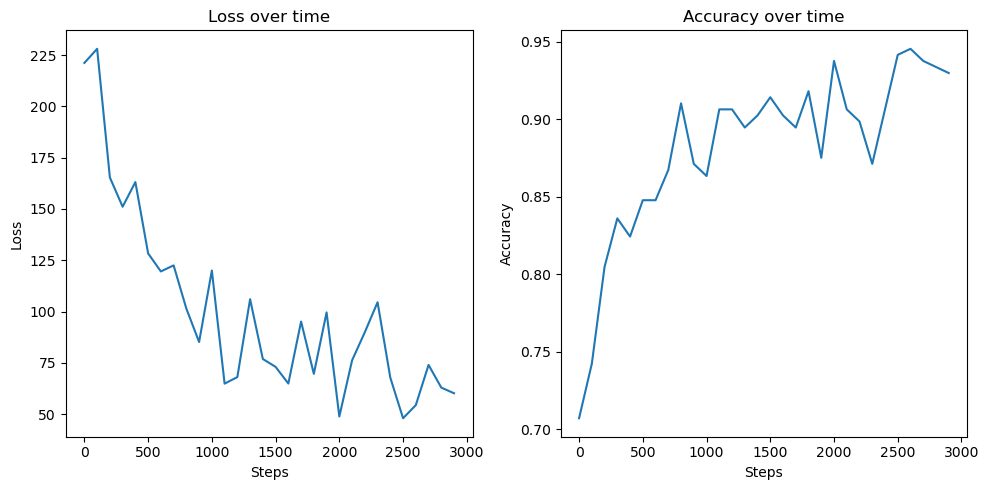

In [28]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, training_steps, display_step), loss_history)
plt.title('Loss over time')
plt.xlabel('Steps')
plt.ylabel('Loss')

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(0, training_steps, display_step), accuracy_history)
plt.title('Accuracy over time')
plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [30]:
# Обчисліть точність навченої нейромережі
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9040


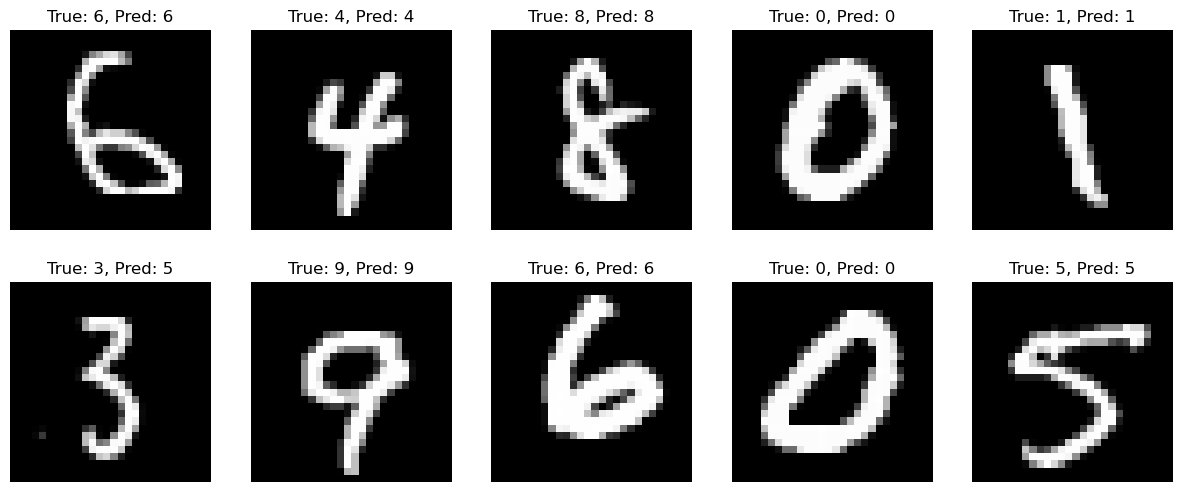

Accuracy on this sample: 0.90


In [58]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_test_images = 10
random_indices = random.sample(range(len(x_test)), num_test_images)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, 1).numpy()

plt.figure(figsize=(15, 6))
for i in range(num_test_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis('off')
plt.show()

# Обчислення точності на цій вибірці
accuracy_sample = np.mean(test_labels == predicted_labels)
print(f"Accuracy on this sample: {accuracy_sample:.2f}")




### Висновки

На деяких тестових даних мережа показує точність 1.00, на деяких 0.9, або 0.8. Це хороші показники точності, які будуть задовільними для багатьох практичних завдать.

Але якщо ситуація (умови дослідження) вимагає більшої точності, то її можна підвищити шляхом збільшення обсягу тренувальної вибірки або зміни архітектури моделі.